<a href="https://colab.research.google.com/github/chaaban17/pytorch-VGG-Model/blob/main/secondModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
import PIL
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
PATH = '/content/drive/My Drive/pytorch model/model2.tar'

cuda:0


In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
vgg19 = models.vgg19(pretrained=True)
vgg19.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
# change the number of classes 
vgg19.classifier[6].out_features = 10
# freeze convolution weights
for param in vgg19.features.parameters():
    param.requires_grad = False

In [7]:
# optimizer
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=0.001)
# loss function
criterion = nn.CrossEntropyLoss()

In [8]:
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)

    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}')
    
    return val_loss, val_accuracy
# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy    

In [11]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(15):
    print('Training... Epoch: ' , epoch)
    train_epoch_loss, train_epoch_accuracy = fit(vgg19, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg19, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    torch.save({
          'epoch': epoch,
          'model_state_dict': vgg19.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': val_loss,
    }, PATH + '/model2-' + str(epoch) + '.pt')
end = time.time()
print((end-start)/60, 'minutes')

Training... Epoch:  0
Train Loss: 0.0066, Train Acc: 71.71
Validation Loss: 0.0053, Validation Acc: 77.45
Training... Epoch:  1
Train Loss: 0.0061, Train Acc: 73.92
Validation Loss: 0.0053, Validation Acc: 76.79
Training... Epoch:  2
Train Loss: 0.0057, Train Acc: 75.38
Validation Loss: 0.0048, Validation Acc: 78.97
Training... Epoch:  3
Train Loss: 0.0055, Train Acc: 76.26
Validation Loss: 0.0048, Validation Acc: 78.98
Training... Epoch:  4
Train Loss: 0.0054, Train Acc: 77.19
Validation Loss: 0.0045, Validation Acc: 81.15
Training... Epoch:  5
Train Loss: 0.0052, Train Acc: 78.10
Validation Loss: 0.0045, Validation Acc: 80.77
Training... Epoch:  6
Train Loss: 0.0050, Train Acc: 78.68
Validation Loss: 0.0045, Validation Acc: 81.09
Training... Epoch:  7
Train Loss: 0.0049, Train Acc: 79.24
Validation Loss: 0.0045, Validation Acc: 81.39
Training... Epoch:  8
Train Loss: 0.0049, Train Acc: 79.20
Validation Loss: 0.0043, Validation Acc: 81.31
Training... Epoch:  9
Train Loss: 0.0048, Trai

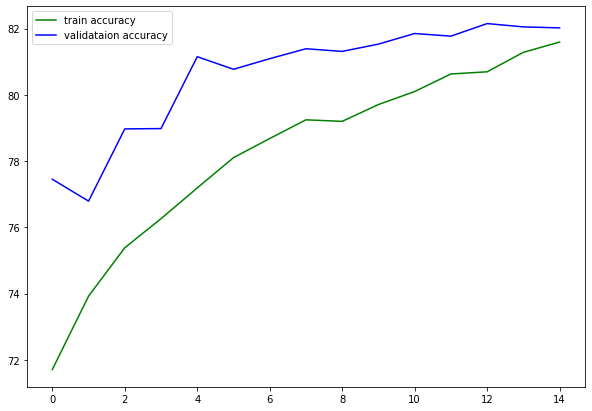

In [12]:

plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.show()

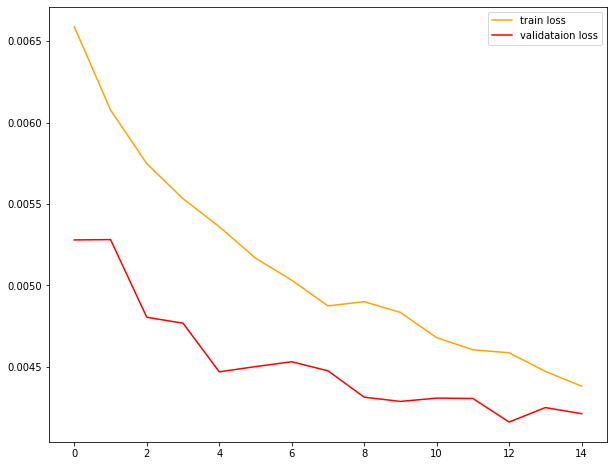

In [13]:
plt.figure(figsize=(10, 8))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.show()

In [17]:
checkpoint = torch.load('/content/drive/My Drive/pytorch model/model2.tar/model2-14.pt')
vgg19.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

